####################################
### Data Preparation
####################################

In [1]:
#Importing required libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
from collections import Counter

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# First few tagged sentences
print(nltk_data[1:15])

[[('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('conglomerate', 'NOUN'), ('.', '.')], [('A', 'DET'), ('form', 'NOUN'), ('of', 'ADP'), ('asbestos', 'NOUN'), ('once', 'ADV'), ('used', 'VERB'), ('*', 'X'), ('*', 'X'), ('to', 'PRT'), ('make', 'VERB'), ('Kent', 'NOUN'), ('cigarette', 'NOUN'), ('filters', 'NOUN'), ('has', 'VERB'), ('caused', 'VERB'), ('a', 'DET

################################################# 
### Splitting into Train-Test Data
#################################################

In [4]:
# Train-Test split
# 95% train sizr and 5% test size
train_set,test_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05,random_state = 42)

In [5]:
# Getting list of train tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
train_tagged_words[1:16]

[('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('New', 'NOUN'),
 ('York', 'NOUN'),
 ('Stock', 'NOUN'),
 ('Exchange', 'NOUN'),
 ('.', '.')]

In [6]:
# Total number of train tagged words
len(train_tagged_words)

95589

In [7]:
# Getting list of test tagged words
test_tagged_words = [tup for sent in test_set for tup in sent]
train_tagged_words[1:16]

[('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP'),
 ('the', 'DET'),
 ('New', 'NOUN'),
 ('York', 'NOUN'),
 ('Stock', 'NOUN'),
 ('Exchange', 'NOUN'),
 ('.', '.')]

In [8]:
# Total number of test tagged words
len(test_tagged_words)

5087

##########################################
### Displaying the tags
##########################################

In [9]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [10]:
print(T)

{'CONJ', 'VERB', 'ADP', '.', 'PRON', 'DET', 'ADJ', 'PRT', 'NUM', 'ADV', 'NOUN', 'X'}


###############################################
### Total Vacabulary
###############################################

In [11]:
# Displaying Tokens in Train Data Set
tokens_train = [pair[0] for pair in train_tagged_words]
tokens_train[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [12]:
# Total Tokens in Train Data Set
V_train = set(tokens_train)
print(len(V_train))

12109


In [13]:
# Displaying Tokens in Test Data Set
tokens_test = [pair[0] for pair in test_tagged_words]
tokens_test[:10]

['For',
 'the',
 'Agency',
 'for',
 'International',
 'Development',
 ',',
 'appropriators',
 'approved',
 '$']

In [14]:
# Total Tokens in Test Data Set
V_test = set(tokens_test)
print(len(V_test))

1872


#################################################################################
### Build the vanilla Viterbi based POS tagger
#################################################################################

### POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

### Emission Probabilities

In [15]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v_train = len(V_train)
w_given_t = np.zeros((t, v_train))

In [16]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [17]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,CONJ,VERB,ADP,.,PRON,DET,ADJ,PRT,NUM,ADV,NOUN,X
CONJ,0.000469,0.153918,0.054435,0.034256,0.058658,0.121539,0.116847,0.004693,0.042234,0.055842,0.349132,0.007977
VERB,0.005588,0.169189,0.090493,0.035312,0.036244,0.133101,0.064649,0.031121,0.022817,0.082577,0.110904,0.218005
ADP,0.000856,0.008240,0.017228,0.039486,0.069128,0.326378,0.105297,0.001498,0.062921,0.013162,0.321776,0.034029
.,0.057924,0.088505,0.091114,0.093812,0.065389,0.173502,0.044972,0.002339,0.080500,0.052078,0.223152,0.026623
PRON,0.004966,0.480901,0.022918,0.041253,0.008021,0.009549,0.074866,0.012223,0.007257,0.033995,0.211230,0.092819
DET,0.000483,0.038387,0.009054,0.017986,0.003742,0.005311,0.204973,0.000241,0.021970,0.012313,0.640029,0.045509
ADJ,0.016949,0.012342,0.078986,0.065328,0.000658,0.005101,0.066645,0.010861,0.020405,0.004608,0.696725,0.021392
PRT,0.002288,0.402746,0.021576,0.041517,0.018960,0.100360,0.086303,0.001635,0.058516,0.010134,0.242563,0.013403
NUM,0.013381,0.017544,0.034790,0.118347,0.001487,0.003271,0.034196,0.027951,0.184062,0.002974,0.355338,0.206661
ADV,0.006312,0.344518,0.119601,0.136877,0.015615,0.067110,0.130233,0.013621,0.030565,0.081063,0.030897,0.023588


In [20]:
tags_df.loc['.', :]

CONJ    0.057924
VERB    0.088505
ADP     0.091114
.       0.093812
PRON    0.065389
DET     0.173502
ADJ     0.044972
PRT     0.002339
NUM     0.080500
ADV     0.052078
NOUN    0.223152
X       0.026623
Name: ., dtype: float32

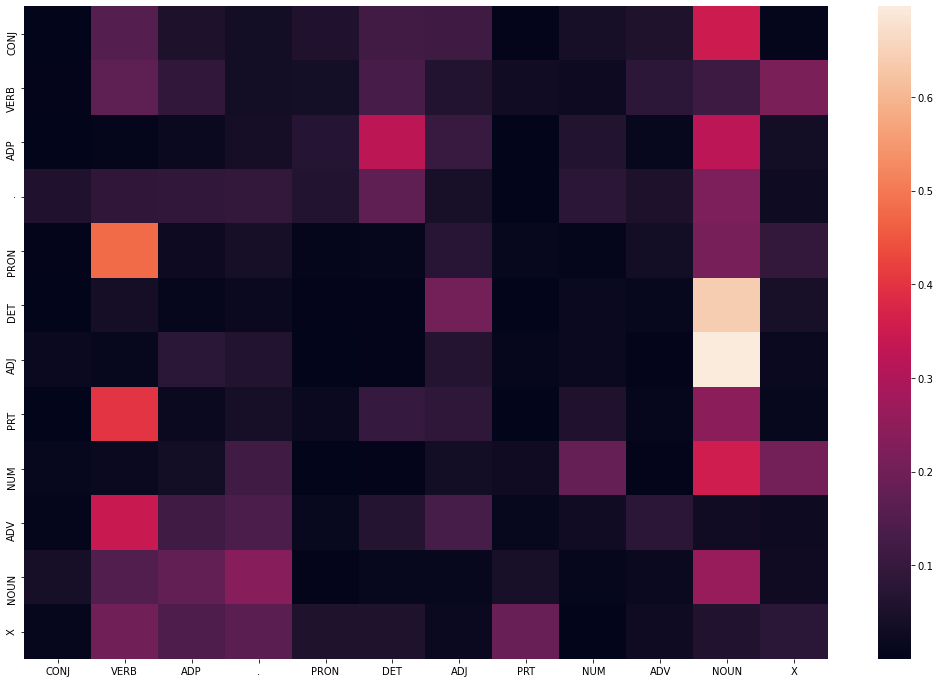

In [21]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

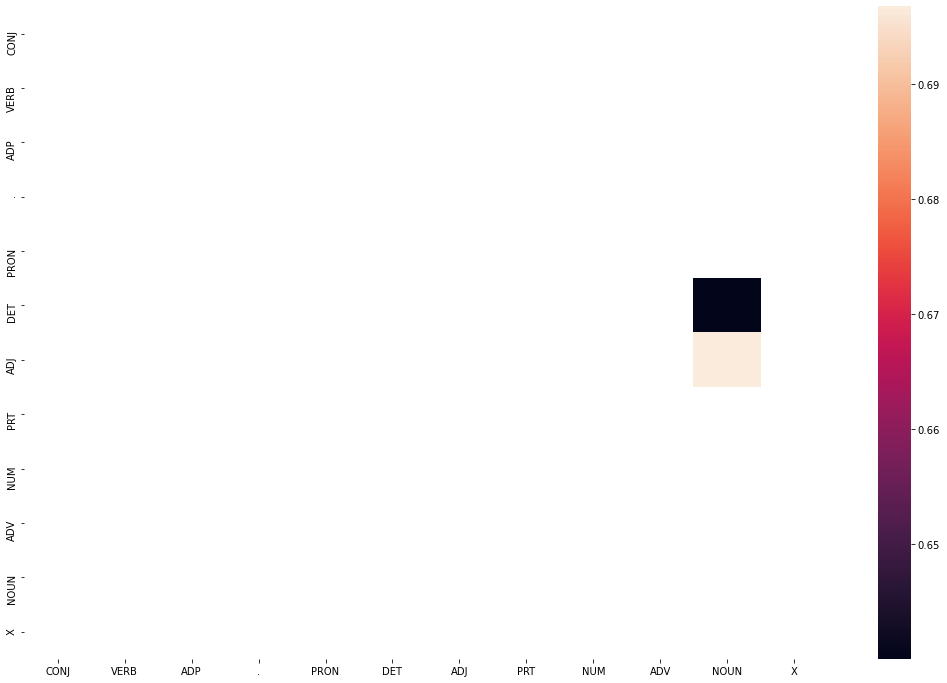

In [22]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [23]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on Test Set

In [24]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 15 sents
rndom = [random.randint(1,len(test_set)) for x in range(15)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Shearson', 'NOUN'),
  ('``', '.'),
  ('really', 'ADV'),
  ('only', 'ADV'),
  ('has', 'VERB'),
  ('$', '.'),
  ('300', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('of', 'ADP'),
  ('capital', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Bowman', 'NOUN'),
  ('of', 'ADP'),
  ('S&P', 'NOUN'),
  ('.', '.')],
 [('ShareData', 'NOUN'),
  ('develops', 'VERB'),
  ('and', 'CONJ'),
  ('markets', 'VERB'),
  ('low-cost', 'ADJ'),
  ('software', 'NOUN'),
  (',', '.'),
  ('peripheral', 'ADJ'),
  ('equipment', 'NOUN'),
  ('and', 'CONJ'),
  ('accessories', 'NOUN'),
  ('for', 'ADP'),
  ('computers', 'NOUN'),
  ('.', '.')],
 [('Moscow', 'NOUN'),
  ('has', 'VERB'),
  ('settled', 'VERB'),
  ('pre-1917', 'ADJ'),
  ('debts', 'NOUN'),
  ('with', 'ADP'),
  ('other', 'ADJ'),
  ('countries', 'NOUN'),
  ('in', 'ADP'),
  ('recent', 'ADJ'),
  ('years', 'NOUN'),
  ('at', 'ADP'),
  ('less', 'ADJ'),
  ('than', 'ADP'),
  ('face', 'NOUN'),
  ('value', 'NOUN'),


In [25]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
print(tagged_seq)

[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'CONJ'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'CONJ'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'CONJ'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', 'NOUN'), ('were', 'VERB'), ('passed', '

In [26]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  167.32692790031433


### Accuracy on Test Set

In [27]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

In [28]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.8924418604651163

### Incorrect tagged cases

In [30]:
incorrect_tagged_cases = [i for i, j in zip(tagged_seq, test_run_base) if i != j] 
incorrect_tagged_cases

[('develops', 'CONJ'),
 ('markets', 'NOUN'),
 ('low-cost', 'CONJ'),
 ('pre-1917', 'CONJ'),
 ('test', 'VERB'),
 ('out', 'PRT'),
 ('copied', 'CONJ'),
 ('154.2', 'CONJ'),
 ('enormously', 'CONJ'),
 ('frustrating', 'CONJ'),
 ('science', 'CONJ'),
 ('raring', 'CONJ'),
 ('invent', 'CONJ'),
 ('Walkman', 'CONJ'),
 ('soliciting', 'CONJ'),
 ('TXO', 'CONJ'),
 ("'s", 'VERB'),
 ('manmade-fiber', 'CONJ'),
 ('405', 'CONJ'),
 ('deplorable', 'CONJ'),
 ('brushed', 'CONJ'),
 ('off', 'ADV'),
 ('talk', 'VERB'),
 ('renewing', 'CONJ'),
 ('insurgents', 'CONJ'),
 ('Iran-Contra', 'CONJ'),
 ('Funded', 'CONJ'),
 ('Tokio', 'CONJ'),
 ('protocols', 'CONJ'),
 ('preventative', 'CONJ'),
 ('Though', 'CONJ'),
 ('acquirers', 'CONJ'),
 ('noticed', 'CONJ'),
 ('Funded', 'CONJ'),
 ('Tokio', 'CONJ'),
 ('protocols', 'CONJ'),
 ('preventative', 'CONJ')]

##################################################################
### Solve the problem of unknown words
##################################################################

### Solution 1 - Probability Based
### For words in the corpus, state probability = transition probability * emission probaility
### For words not in the corpus, state probability = transition probability

In [31]:
# If Emission probability is zero than use Transistion probability only

# Viterbi Heuristic
def Viterbi_modified1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p_state_probability = [] 
        p_transition_probability = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p_state_probability.append(state_probability)
            p_transition_probability.append(transition_p)
            
        pmax = max(p_state_probability)
        # getting state for which probability is maximum
        state_max = T[p_state_probability.index(pmax)]
        
        # If Emission probability is zero, than use transistion probability
        if pmax == 0:
            pmax = max(p_transition_probability)
            # getting state for which probability is maximum
            state_max = T[p_transition_probability.index(pmax)]
        else:
            pmax = max(p_state_probability)
            # getting state for which probability is maximum
            state_max = T[p_state_probability.index(pmax)]                     
            
        state.append(state_max)
    return list(zip(words, state))

In [32]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modified1(test_tagged_words)
end = time.time()
print(tagged_seq)

[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'NOUN'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'NOUN'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'X'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', 'NOUN'), ('were', 'VERB'), ('passed', 'VER

In [33]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  192.85361766815186


### Accuracy on Test Set - Viterbi Modified 1

In [34]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [35]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.938953488372093

### Incorrect tagged cases

In [36]:
incorrect_tagged_cases = [i for i, j in zip(tagged_seq, test_run_base) if i != j] 
incorrect_tagged_cases

[('develops', 'NOUN'),
 ('markets', 'NOUN'),
 ('low-cost', 'NOUN'),
 ('pre-1917', 'X'),
 ('test', 'VERB'),
 ('out', 'PRT'),
 ('154.2', 'X'),
 ('enormously', 'X'),
 ('raring', 'X'),
 ('soliciting', 'X'),
 ('TXO', 'X'),
 ('manmade-fiber', 'DET'),
 ('405', 'NOUN'),
 ('deplorable', 'NOUN'),
 ('brushed', 'NOUN'),
 ('talk', 'VERB'),
 ('Tokio', 'DET'),
 ('preventative', 'DET'),
 ('Though', 'NOUN'),
 ('Tokio', 'DET'),
 ('preventative', 'DET')]

### Solution 2 - Rule Based
### Assign all unknown words the most frequent POS tag of the corpus

In [37]:
# Maximum used tag in the complete corpus
corpus_tagged_words = [tup for sent in nltk_data for tup in sent]
tag_corpus = [pair[1] for pair in corpus_tagged_words]
counts_tag = Counter(tag_corpus)
most_common_tag_counts = counts_tag.most_common(1)
most_common_tag = most_common_tag_counts[0]
most_common_tag[0]

'NOUN'

In [38]:
# Replace the tag for unknown words with the most common occuring Tag in the complete Corpus

# Viterbi Heuristic
def Viterbi_modified2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p_state_probability = [] 
        p_transition_probability = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p_state_probability.append(state_probability)
            p_transition_probability.append(transition_p)
            
        pmax = max(p_state_probability)
        # getting state for which probability is maximum
        state_max = T[p_state_probability.index(pmax)]
        
        # If Emission probability is zero, than use transistion probability
        if pmax == 0:
            state_max = most_common_tag[0]
        else:
            pmax = max(p_state_probability)
            # getting state for which probability is maximum
            state_max = T[p_state_probability.index(pmax)]                     
            
        state.append(state_max)
    return list(zip(words, state))

In [39]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modified2(test_tagged_words)
end = time.time()
print(tagged_seq)

[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'NOUN'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'NOUN'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'NOUN'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets', 'NOUN'), ('were', 'VERB'), ('passed', '

In [40]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  182.20974493026733


In [41]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [42]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9273255813953488

In [43]:
incorrect_tagged_cases = [i for i, j in zip(tagged_seq, test_run_base) if i != j] 
incorrect_tagged_cases

[('develops', 'NOUN'),
 ('markets', 'NOUN'),
 ('low-cost', 'NOUN'),
 ('pre-1917', 'NOUN'),
 ('test', 'VERB'),
 ('out', 'PRT'),
 ('copied', 'NOUN'),
 ('154.2', 'NOUN'),
 ('enormously', 'NOUN'),
 ('frustrating', 'NOUN'),
 ('raring', 'NOUN'),
 ('invent', 'NOUN'),
 ('soliciting', 'NOUN'),
 ('manmade-fiber', 'NOUN'),
 ('405', 'NOUN'),
 ('deplorable', 'NOUN'),
 ('brushed', 'NOUN'),
 ('talk', 'VERB'),
 ('renewing', 'NOUN'),
 ('Funded', 'NOUN'),
 ('preventative', 'NOUN'),
 ('Though', 'NOUN'),
 ('noticed', 'NOUN'),
 ('Funded', 'NOUN'),
 ('preventative', 'NOUN')]

###############################################################################################################################
### Evaluating the complete Test Data Set on the Vanilla Viterbi Algorithm and modified Viterbi (Solution 1 and Solution 2)
###############################################################################################################################

In [44]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

In [45]:
# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

### Evaluating complete Test Data on the Vanilla Viterbi

In [46]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
print(tagged_seq)

[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'CONJ'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package', 'NOUN'), ('.', '.'), ('The', 'DET'), 

In [47]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  2495.1171402931213


In [48]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [50]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.913701592294083

### Evaluating complete Test Data on the modifled Viterbi - Solution 1 - Probability Based
### For words in the corpus, state probability = transition probability * emission probaility
### For words not in the corpus, state probability = transition probability

In [51]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modified1(test_tagged_words)
end = time.time()
print(tagged_seq)

[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package', 'NOUN'), ('.', '.'), ('The', 'DET'), 

In [52]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  2147.3045995235443


In [53]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [54]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9388637703951248

### Evaluating complete Test Data on the modifled Viterbi - Solution 2 - Rule Based
### Assign all unknown words the most frequent POS tag of the corpus

In [55]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_modified2(test_tagged_words)
end = time.time()
print(tagged_seq)

[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('package', 'NOUN'), ('.', '.'), ('The', 'DET'), 

In [56]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  2742.8710153102875


In [57]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [58]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9396500884607824

###############################################################################################################################
### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm
###############################################################################################################################

### The tagging accuracy of the test set for Vanilla Viterbi Algorithm is: 0.9137
### The tagging accuracy of the test set for modified Viterbi Algorithm - Solution 1 is: 0.9388
### The tagging accuracy of the test set for modified Viterbi Algorithm - Solution 2 is: 0.9396 

### Thus it could be seen that the tagging accuracy has increased in the modified Viterbi Algorithm for Solution 1 and Solution 2

###############################################################################################################################
### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications
###############################################################################################################################

### The cases which were originally tagged incorrectly by Vanilla Viterbi based POS tagger are:
####  ('science', 'CONJ'),  ('Walkman', 'CONJ'), ('protocols', 'CONJ'),  ('acquirers', 'CONJ')

### Using the modified Viterbi Algorithm for Solution 1 and Solution 2, the originally incorrectly tagged cases were corrected as below:
#### ('science', 'NOUN), ('Walkman','NOUN), ('protocols', 'NOUN'),  ('acquirers', 'NOUN')

####################################################################################
### Running the sample test file provided
#####################################################################################

In [74]:
# Open, read and close the Test_sentences file
test_sentences_file = open("Test_sentences.txt","r")
test_sentences = test_sentences_file.read()
sample_test_file = test_sentences.splitlines()
sample_test_file = sample_test_file[:-3] # There are 3 blanks at the end of the Test_sentences.txt file
test_sentences_file.close()
sample_test_file

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [75]:
# list of untagged words
test_file_words = [tup for sent in sample_test_file for tup in sent.split()]
test_file_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 "Twitter's",
 'firehose.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets.',
 'Before',
 'entering',
 'politics,',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup,',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years.',
 'This',
 'is',
 'the',
 'first',
 'World',

### Tagging the words using Vanilla Viterbi Algorithm

In [76]:
# tagging the words
start = time.time()
tagged_seq = Viterbi(test_file_words)
end = time.time()
print(tagged_seq)

[('Android', 'CONJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'CONJ'), ('Android', 'CONJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'CONJ'), ('worldwide', 'CONJ'), ('on', 'ADP'), ('smartphones', 'CONJ'), ('since', 'ADP'), ('2011', 'CONJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'CONJ'), ('Google', 'CONJ'), ('and', 'CONJ'), ('Twitter', 'CONJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'CONJ'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'CONJ'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'CONJ'), ('firehose.', 'CONJ'), ('Twitter', 'CONJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'CONJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and',

In [77]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  91.78271150588989


### Tagging the words in modified Viterbi algorithm - Solution 1 - Probability Based
### For words in the corpus, state probability = transition probability * emission probaility
### For words not in the corpus, state probability = transition probability

In [78]:
# tagging the words
start = time.time()
tagged_seq = Viterbi_modified1(test_file_words)
end = time.time()
print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'DET'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'DET'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'VERB'), ('firehose.', 'X'), ('Twitter', 'VERB'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), (

In [79]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  89.94888973236084


### Tagging the words in modified Viterbi algorithm - Solution 2 - Rule Based
### Assign all unknown words the most frequent POS tag of the corpus

In [80]:
# tagging the words
start = time.time()
tagged_seq = Viterbi_modified2(test_file_words)
end = time.time()
print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'NOUN'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose.', 'NOUN'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and',

In [81]:
# Printing the time
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  93.31270909309387


### Words incorrectly tagged by Vanilla Viterbi Algorithm
#### ('Android', 'CONJ'), ('Twitter', 'CONJ'), ('Cup,', 'CONJ'), ('tournament', 'CONJ')

### The above mentioned incorrect taggin was corrected as shown below using both the modified Viterbi methods  - Solution 1 and Solution 2
#### ('Android', 'NOUN'), ('Twitter', 'NOUN'), ('Cup,', 'NOUN'), ('tournament', 'NOUN')